# Resampling Techniques

1.  Synthetic Minority Over Sampling Technique (SMOTE)

2. UnderSampling

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Pandas and numpy for data manipulation
%matplotlib inline
import pandas as pd
import numpy as np

# Matplotlib  for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale and style
sns.set(font_scale = 1.5)
sns.set_style('ticks')
sns.set()

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Pickle
import joblib

# Data pre-processing
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

# Import under sampling module from imbalanced learn
from imblearn.under_sampling import RandomUnderSampler
# Import SMOTE from imbalanced learn
from imblearn.over_sampling import SMOTE

# Machine learning models
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Grid search and model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Model performance metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc,recall_score
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve

In [2]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

## Load Cleaned  Data

In [3]:
df = pd.read_csv('../data/cleaned_data_2014_to_2017.csv')
df.head()

,Record,Location,X,Y,Date,Time,Environment,Road_Surface,Traffic_Control,Collision_Location,Light,Collision_Classification,Impact_type,Year,Month,Week_day
0,1,RIDEAU ST @ WALLER ST,368282.69327,5.032275e+06,2014-02-21,06:07:00,02 - Rain,02 - Wet,01 - Traffic signal,03 - At intersection,07 - Dark,01 - Fatal injury,07 - SMV other,2014,February,Friday
1,2,HINES RD btwn INNOVATION DR & SOLANDT RD,350172.08885,5.022740e+06,2014-08-02,13:55:00,01 - Clear,01 - Dry,10 - No control,04 - At/near private drive,01 - Daylight,01 - Fatal injury,02 - Angle,2014,August,Saturday
2,3,LOGGERS WAY btwn KINGDON MINE RD & GALETTA SID...,NaN,5.033218e+06,2014-06-20,23:15:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,07 - Dark,01 - Fatal injury,07 - SMV other,2014,June,Friday
3,4,MONTREAL RD @ BATHGATE DR/BURMA RD,373224.24847,5.034518e+06,2014-07-29,16:31:00,01 - Clear,01 - Dry,01 - Traffic signal,03 - At intersection,01 - Daylight,01 - Fatal injury,05 - Turning movement,2014,July,Tuesday
4,5,RICHMOND RD btwn FALLOWFIELD RD & RUSHMORE RD,358156.20481,5.012570e+06,2014-08-05,20:05:00,01 - Clear,01 - Dry,10 - No control,01 - Non intersection,05 - Dusk,01 - Fatal injury,07 - SMV other,2014,August,Tuesday


In [4]:
# Data Shape
df.shape

(58338, 16)

In [5]:
# Datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58338 entries, 0 to 58337
Data columns (total 16 columns):
Record                      58338 non-null int64
Location                    58338 non-null object
X                           57768 non-null float64
Y                           58338 non-null float64
Date                        58338 non-null object
Time                        58338 non-null object
Environment                 58337 non-null object
Road_Surface                58338 non-null object
Traffic_Control             58302 non-null object
Collision_Location          58332 non-null object
Light                       58336 non-null object
Collision_Classification    58338 non-null object
Impact_type                 58338 non-null object
Year                        58338 non-null int64
Month                       58338 non-null object
Week_day                    58338 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 7.1+ MB


Observation

- There are 3 numerical  and 12 categorical attributes in the dataset

-  Traffic_Control, Collision_Location, and Light have missing values. We will come back to the missing values later in data preprocessing.


In [6]:
# Drop speified attributes 
df = df.drop(['Time', 'Date', 'Record','Location'], axis = 1)

In [7]:
# Attrinute names
df.columns

Index(['X', 'Y', 'Environment', 'Road_Surface', 'Traffic_Control',
       'Collision_Location', 'Light', 'Collision_Classification',
       'Impact_type', 'Year', 'Month', 'Week_day'],
      dtype='object')

## Class Distribution

In [8]:
df.Collision_Classification.value_counts()/len(df)*100

03 - P.D. only           80.990092
02 - Non-fatal injury    18.840207
01 - Fatal injury         0.169701
Name: Collision_Classification, dtype: float64

The P.D only and the Non-fatal injury classes can be combined to form a general Non-fatal injury class reducing the dataset to a binary class problem. We will do this is during the data preprocessing. For now we will use the three classes in the exploratory data analysis (EDA)

In [9]:
df.Collision_Classification = df.Collision_Classification.replace('03 - P.D. only', '02 - Non-fatal injury').\
replace('02 - Non-fatal injury', 'Non-fatal injury')

In [10]:
df.Collision_Classification = df.Collision_Classification.replace('01 - Fatal injury', 'Fatal injury')

In [11]:
df.Collision_Classification.value_counts()/len(df)*100

Non-fatal injury    99.830299
Fatal injury         0.169701
Name: Collision_Classification, dtype: float64

##  Feature Matrix  and Class Variable

In [12]:
X, y = df.drop(['Collision_Classification'], axis = 1), df['Collision_Classification']

## Create a Test Set

In [13]:
# Create 70% training set and 30% test set using stratify sampling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= 42, stratify = y)

In [14]:
print('Training set size:', X_train.shape, y_train.shape)
print('Test set size:', X_test.shape, y_test.shape)

Training set size: (40836, 11) (40836,)
Test set size: (17502, 11) (17502,)


## Impute Missing Value

As we saw above, there are some attributes with missing values. We will now impute the missing values in those attributes using mode for categorical variables and median for numerical variables

In [15]:
# Instantiate the imputer class
imputer = DataFrameImputer()

# Fit transform the training set
X_train_imputed = imputer.fit_transform(X_train)

# Only transform the test set
X_test_imputed = imputer.fit_transform(X_test)

##  Feature Scaling and Handling Categorical Attributes

As we saw above, most of the attributes are categorical, and they need to be converted to numeric before applying the machine learning algorithms. We also need to scale the numerical attributes for a better performance

In [16]:
# Numerical attributes list
num_list = list(X.select_dtypes('number'))

# Categorical attributes list
cat_list = list(X.select_dtypes('O'))

# Standardize the numerical attributes
num_attribs = [([num], StandardScaler()) for num in num_list]

# Binarize the categorical attributes
cat_attribs = [([cat], LabelBinarizer()) for cat in cat_list]

# Build a pipeline for the data pre-processing
mapper =  DataFrameMapper(num_attribs + cat_attribs)

# Fit transform the training set
X_train_prepared = mapper.fit_transform(X_train_imputed)

# Only transform the test set
X_test_prepared = mapper.transform(X_test_imputed)

In [17]:
print('Training set size after pre-processing:', X_train_prepared.shape)
print('Test set size after pre-processing:', X_test_prepared.shape)

Training set size after pre-processing: (40836, 78)
Test set size after pre-processing: (17502, 78)


##  Encode the Class Variable

In [18]:
# Dictionary mapping
map_target = {'Fatal injury': 1, 'Non-fatal injury': 0}

# Map to discrete numbers
y_train_label = y_train.map(map_target)
y_test_label = y_test.map(map_target)

# Model (Cross-validation)

We train Random forest classifier on the imbalanced dataset, We also apply grid search and resampling methods

## Random Forest  Classifier

The problem of class imbalance is clearly manifested in this dataset. Below we see that the overall accuracy is misleading as the classifier predicted only the majority class

In [21]:
rf_clf = RandomForestClassifier(random_state = 42)
model_selection_cv(rf_clf, X_train_prepared, y_train_label, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998393 (0.000000)
AUROC: 0.509337
AUPRC: 0.001684
Predicted classes: [0]
Confusion matrix:
 [[40372     0]
 [   65     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40372
           1       0.00      0.00      0.00        65

    accuracy                           1.00     40437
   macro avg       0.50      0.50      0.50     40437
weighted avg       1.00      1.00      1.00     40437

****************************************************************************


## Grid Search

We will use grid search to find the optimal hyperparameters that maximizes the RECALL

In [22]:
# Class ratio of the negative class to the positive class
neg = y_train_label == 0
pos = y_train_label == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

621.1076923076923

In [23]:
# Range of hyperparameters
params = {'max_features': [1, 0.5, 'sqrt', 'log2'],
          'min_samples_leaf':[1,3,5,10,30]}
               
# Randomized Search
rf_clf = RandomForestClassifier(n_estimators = 500, random_state = 42, class_weight = {0:1, 1:class_ratio})
rsearch_rf = RandomizedSearchCV(estimator = rf_clf, param_distributions = params,scoring = 'recall',
                                cv = 5,n_jobs = -1, random_state = 42, verbose = 1)
                                
# Fit the  training set                                                                                          
rsearch_rf.fit(X_train_prepared, y_train_label)

# Print score
print('Best Recall Score:', rsearch_rf.best_score_) 
print('Best hyperparameters:', rsearch_rf.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 12.2min finished


Best Recall Score: 0.200003424129843
Best hyperparameters: {'min_samples_leaf': 10, 'max_features': 1}


# Resampling Methods

In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## 1. Under sampling of the majority class
In undersampling, we reduce the majority class such that it matches the minority class

In [24]:
# Undersample the majority class
und = RandomUnderSampler(ratio = 'majority', random_state = 42)
X_train_scale_und, y_train_und = und.fit_sample(X_train_prepared, y_train_label)

In [25]:
print('Undersampled training data size:', X_train_scale_und.shape, y_train_und.shape)
print('Imbalanced training set class distribution:', np.bincount(y_train_label))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Undersampled training data size: (130, 78) (130,)
Imbalanced training set class distribution: [40372    65]
Undersampled training set class distribution: [65 65]


### A.  Random forest cross-validation on the undersampled dataset

In [26]:
rf_clf_und = RandomForestClassifier(n_estimators = 1000, random_state = 42)
model_selection_cv(rf_clf_und, X_train_scale_und, y_train_und, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.715385 (0.039223)
AUROC: 0.788521
AUPRC: 0.733659
Predicted classes: [0 1]
Confusion matrix:
 [[47 18]
 [19 46]]
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.72        65
           1       0.72      0.71      0.71        65

    accuracy                           0.72       130
   macro avg       0.72      0.72      0.72       130
weighted avg       0.72      0.72      0.72       130

****************************************************************************


## 2. Synthetic Minority Over Sampling Technique (SMOTE)
In SMOTE, we generate synthetic oberservations to match the minority class

In [25]:
?SMOTE

In [30]:
# Oversample the minority class
sm = SMOTE(ratio = None, sampling_strategy = 0.2, random_state = 42)
X_train_scale_ovsm, y_train_ovsm = sm.fit_sample(X_train_prepared, y_train_label)

In [31]:
print('SMOTE training data size:', X_train_scale_ovsm.shape, y_train_ovsm.shape)
print('Imbalanced training set class distribution:', np.bincount(y_train_label))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

SMOTE training data size: (48920, 78) (48920,)
Imbalanced training set class distribution: [40767    69]
SMOTE resampled training set class distribution: [40767  8153]


### B. Random forest cross-validation on the SMOTE dataset

In [32]:
rf_clf_sm = RandomForestClassifier(random_state = 42)
model_selection_cv(rf_clf_sm, X_train_scale_ovsm, y_train_ovsm, cv_fold = 5, scoring = 'accuracy')

****************************************************************************
Cross-validation accuracy (std): 0.998263 (0.002916)
AUROC: 0.998281
AUPRC: 0.997038
Predicted classes: [0 1]
Confusion matrix:
 [[40764     3]
 [   82  8071]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     40767
           1       1.00      0.99      0.99      8153

    accuracy                           1.00     48920
   macro avg       1.00      0.99      1.00     48920
weighted avg       1.00      1.00      1.00     48920

****************************************************************************


#  ROC and PR Curves on the Cross-Validation Training Set


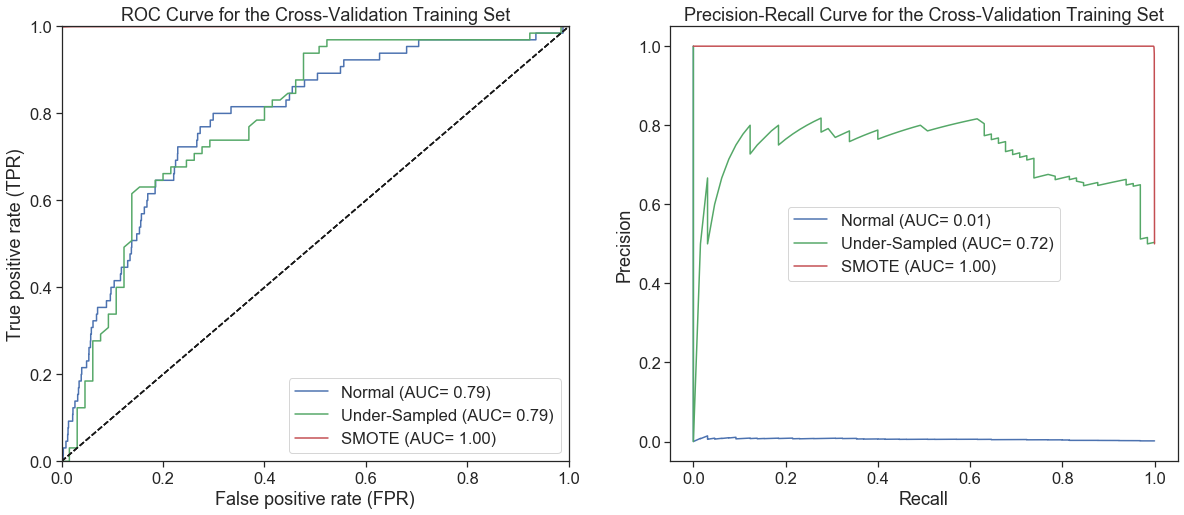

In [30]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR curves for normal imbalanced distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rsearch_rf.best_estimator_, X_train_prepared, y_train_label,
                       color= 'b', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR curves for Under Sampled distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rf_clf_und, X_train_scale_und, y_train_und,
                       color= 'g', label = 'Under-Sampled (AUC= %0.2f)')
                     
# Plot ROC and PR curves for SMOTE distribution
Plot_ROC_Curve_and_PRC_Cross_Val(rf_clf_sm, X_train_scale_ovsm, y_train_ovsm,
                       color= 'r', label = 'SMOTE (AUC= %0.2f)') 

# Prediction on the Test Set

Let's make prediction on the imbalanced Test Set

## 1. Normal Imbalanced dataset

In [31]:
rf_best = rsearch_rf.best_estimator_
Test_Prediction(rf_best, X_train_prepared, y_train_label, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.952974
AUROC: 0.774979
AUPRC: 0.006645
Predicted classes: [0 1]
Confusion matrix:
 [[16509   794]
 [   21     7]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98     17303
           1       0.01      0.25      0.02        28

    accuracy                           0.95     17331
   macro avg       0.50      0.60      0.50     17331
weighted avg       1.00      0.95      0.97     17331

****************************************************************************


## 2. Undersampled dataset

In [32]:
Test_Prediction(rf_clf_und, X_train_scale_und, y_train_und, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.655992
AUROC: 0.773160
AUPRC: 0.006519
Predicted classes: [0 1]
Confusion matrix:
 [[11348  5955]
 [    7    21]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.79     17303
           1       0.00      0.75      0.01        28

    accuracy                           0.66     17331
   macro avg       0.50      0.70      0.40     17331
weighted avg       1.00      0.66      0.79     17331

****************************************************************************


## 3. SMOTE dataset

In [33]:
Test_Prediction(rf_clf_sm, X_train_scale_ovsm, y_train_ovsm, X_test_prepared, y_test_label)

****************************************************************************
Test accuracy:  0.998172
AUROC: 0.523385
AUPRC: 0.002977
Predicted classes: [0 1]
Confusion matrix:
 [[17470     2]
 [   30     0]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     17472
           1       0.00      0.00      0.00        30

    accuracy                           1.00     17502
   macro avg       0.50      0.50      0.50     17502
weighted avg       1.00      1.00      1.00     17502

****************************************************************************


# ROC  and PR Curves on the Test Set

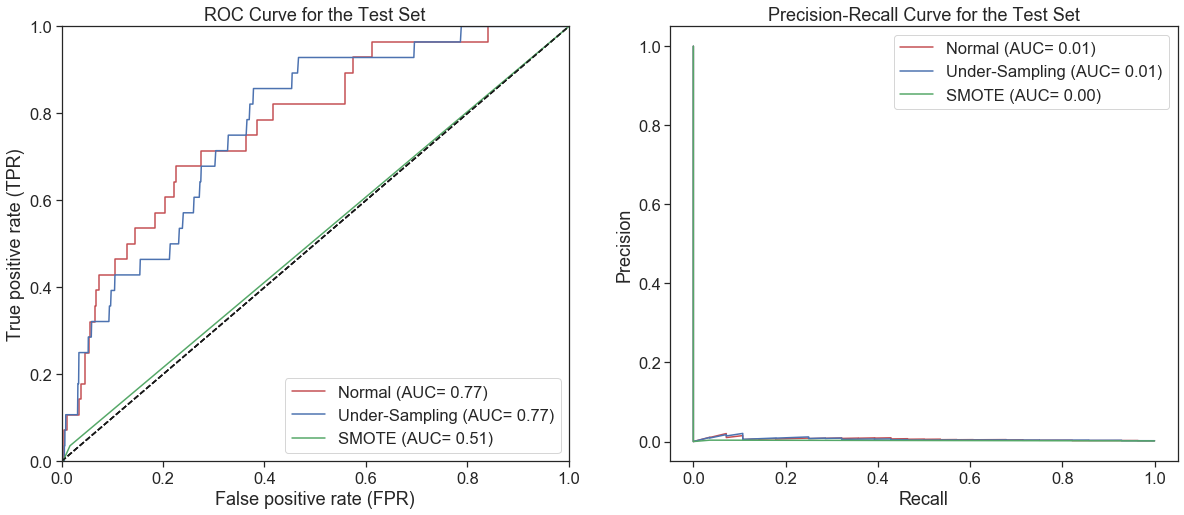

In [36]:
# Set figure and font sizes
fig = plt.figure(figsize = (20,8))
plt.rcParams.update({'font.size':20})
sns.set(font_scale = 1.5)
sns.set_style('ticks')

# Plot ROC and PR Curves for LR
Plot_ROC_Curve_and_PRC(rf_best, X_train_prepared, y_train_label, X_test_prepared, y_test_label,
                     color= 'r', label = 'Normal (AUC= %0.2f)')

# Plot ROC and PR Curves for Under-Smapling
Plot_ROC_Curve_and_PRC(rf_clf_und, X_train_scale_und, y_train_und, X_test_prepared, y_test_label,
                        color= 'b', label = 'Under-Sampling (AUC= %0.2f)')

# Plot ROC and PR Curves for XGB
# Plot ROC and PR Curves for Under-Smapling
Plot_ROC_Curve_and_PRC(rf_clf_sm, X_train_scale_ovsm, y_train_ovsm, X_test_prepared, y_test_label,
                        color= 'g', label = 'SMOTE (AUC= %0.2f)')